In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os


In [1]:
import os
from sklearn.model_selection import train_test_split

# Paths to directories
sar_dir = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/urban/s1"
optical_dir = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/urban/s2"

# Get a list of image files (assuming both SAR and optical images have matching filenames)
sar_images = sorted(os.listdir(sar_dir))
optical_images = sorted(os.listdir(optical_dir))

# Split data into training, validation, and test sets (80% train, 10% validation, 10% test)
train_sar, temp_sar, train_optical, temp_optical = train_test_split(sar_images, optical_images, test_size=0.2, random_state=42)
val_sar, test_sar, val_optical, test_optical = train_test_split(temp_sar, temp_optical, test_size=0.5, random_state=42)

# Create lists of full file paths for training, validation, and test sets
train_set = [(os.path.join(sar_dir, img), os.path.join(optical_dir, img)) for img in train_sar]
val_set = [(os.path.join(sar_dir, img), os.path.join(optical_dir, img)) for img in val_sar]
test_set = [(os.path.join(sar_dir, img), os.path.join(optical_dir, img)) for img in test_sar]

# Print the number of images in each set
print(f"Training set: {len(train_set)} images")
print(f"Validation set: {len(val_set)} images")
print(f"Test set: {len(test_set)} images")


Training set: 3200 images
Validation set: 400 images
Test set: 400 images


In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class SAROpticalDataset(Dataset):
    def __init__(self, sar_images, optical_images, sar_dir, optical_dir, transform=None):
        self.sar_images = sar_images  # list of SAR image filenames
        self.optical_images = optical_images  # list of Optical image filenames
        self.sar_dir = sar_dir  # directory of SAR images
        self.optical_dir = optical_dir  # directory of Optical images
        self.transform = transform

    def __len__(self):
        return min(len(self.sar_images), len(self.optical_images))

    def __getitem__(self, idx):
        # Get image filenames
        sar_image_path = os.path.join(self.sar_dir, self.sar_images[idx])
        optical_image_path = os.path.join(self.optical_dir, self.optical_images[idx])
        
        # Load images
        sar_image = Image.open(sar_image_path).convert("RGB")
        optical_image = Image.open(optical_image_path).convert("RGB")

        if self.transform:
            sar_image = self.transform(sar_image)
            optical_image = self.transform(optical_image)

        return sar_image, optical_image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


In [4]:
# Create instances of the dataset
train_dataset = SAROpticalDataset(train_sar, train_optical, sar_dir, optical_dir, transform=transform)
val_dataset = SAROpticalDataset(val_sar, val_optical, sar_dir, optical_dir, transform=transform)
test_dataset = SAROpticalDataset(test_sar, test_optical, sar_dir, optical_dir, transform=transform)

# Create DataLoader instances
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

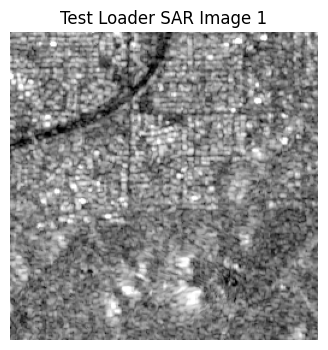

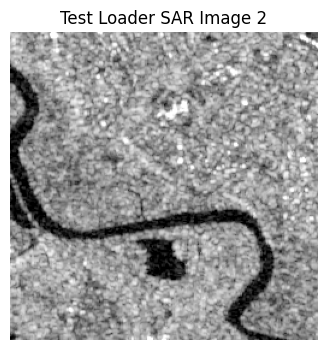

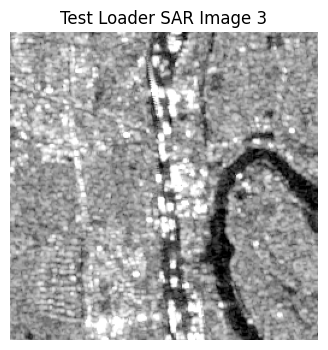

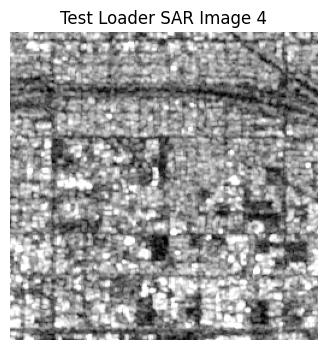

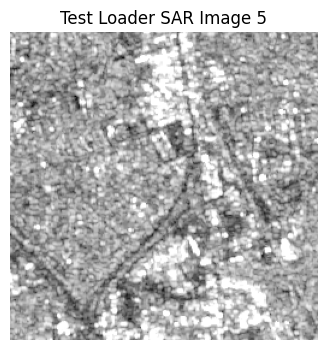

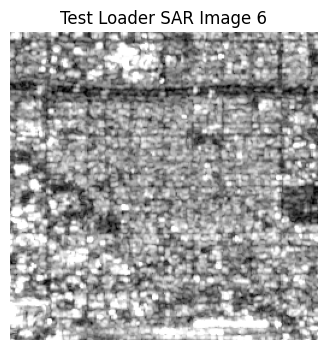

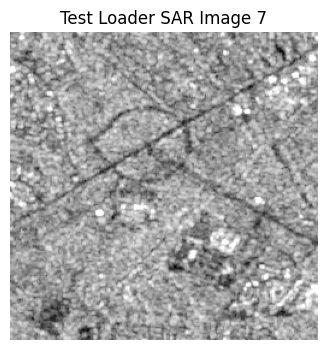

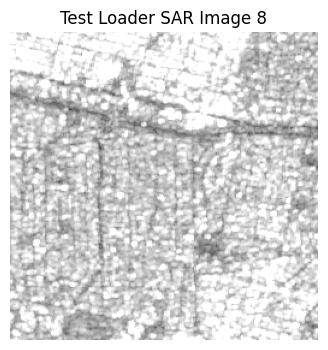

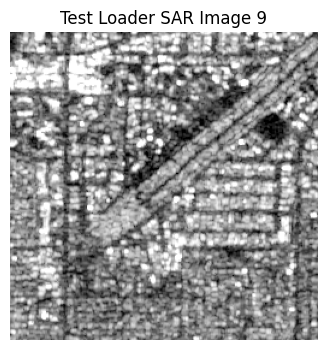

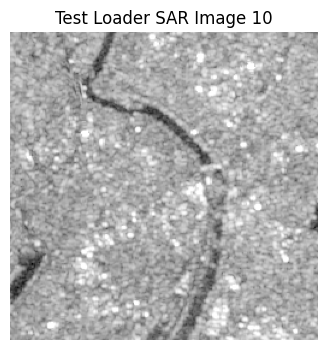

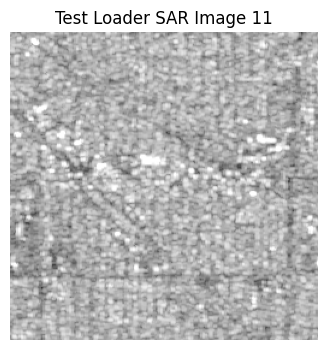

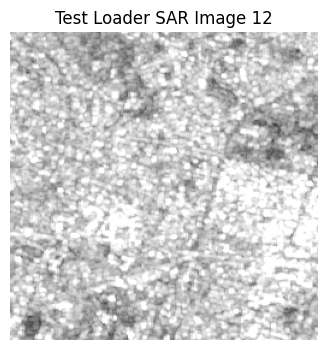

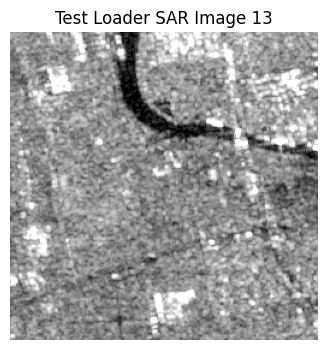

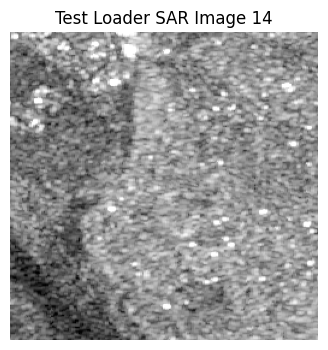

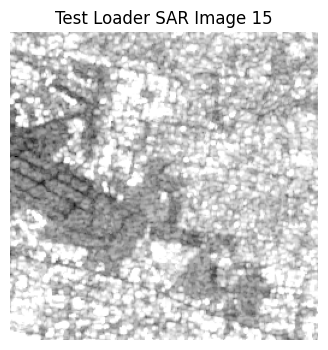

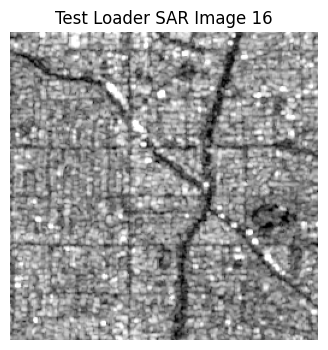

In [8]:
import torch
import matplotlib.pyplot as plt

# Function to display a batch of images from the test loader
def display_test_loader_images(test_loader, num_batches=1):
    with torch.no_grad():  # No need to track gradients
        for i, (sar_images, _) in enumerate(test_loader):  # Get SAR images from the DataLoader
            if i >= num_batches:
                break  # Display only the desired number of batches

            # Convert batch of SAR images to NumPy and display each image
            for j in range(sar_images.size(0)):  # Loop over each image in the batch
                sar_image_np = sar_images[j].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format
                sar_image_np = sar_image_np.clip(0, 1)  # Clip values to valid range

                # Plot each SAR image
                plt.figure(figsize=(4, 4))
                plt.imshow(sar_image_np)
                plt.title(f"Test Loader SAR Image {i * sar_images.size(0) + j + 1}")
                plt.axis('off')
                plt.show()

# Example usage with your test DataLoader
display_test_loader_images(test_loader, num_batches=1)


In [ ]:
import torch
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        
        # Encoder
        self.encoder1 = self.contracting_block(3, 64)    # Input: 256x256, Output: 128x128
        self.encoder2 = self.contracting_block(64, 128)   # Output: 64x64
        self.encoder3 = self.contracting_block(128, 256)  # Output: 32x32
        self.encoder4 = self.contracting_block(256, 512)  # Output: 16x16
        self.bottleneck = self.contracting_block(512, 1024)  # Output: 8x8

        # Decoder
        self.decoder4 = self.expansive_block(1024, 512) 
        self.decoder3 = self.expansive_block(1024, 256)   
        self.decoder2 = self.expansive_block(512, 128)   
        self.decoder1 = self.expansive_block(256, 64)     
        
        self.final_conv = nn.Conv2d(128, 3, kernel_size=1)  # Adjusted to take 128 input channels

    def contracting_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),  # Downsampling
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def expansive_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),  # Upsampling
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # 128x128
        enc2 = self.encoder2(enc1)  # 64x64
        enc3 = self.encoder3(enc2)  # 32x32
        enc4 = self.encoder4(enc3)  # 16x16
        bottleneck = self.bottleneck(enc4)  # 8x8

        # Decoder
        dec4 = self.decoder4(bottleneck)  # 16x16
        dec4 = torch.cat((dec4, enc4), dim=1)  # Skip connection
        dec3 = self.decoder3(dec4)  # 32x32
        dec3 = torch.cat((dec3, enc3), dim=1)  # Skip connection
        dec2 = self.decoder2(dec3)  # 64x64
        dec2 = torch.cat((dec2, enc2), dim=1)  # Skip connection
        dec1 = self.decoder1(dec2)  # 128x128
        dec1 = torch.cat((dec1, enc1), dim=1)  # Skip connection

        # Final output to get 256x256
        output = nn.functional.interpolate(dec1, size=(256, 256), mode='bilinear', align_corners=False)  # Ensure output is 256x256
        output = self.final_conv(output)  # Output: 256x256
        return output

# Example usage
model = UNetGenerator()
input_tensor = torch.randn(1, 3, 256, 256)  # Batch size of 1, 3 channels, 256x256 image
output_tensor = model(input_tensor)
print("Output tensor shape:", output_tensor.shape)  # Should print: Output tensor shape: torch.Size([1, 3, 256, 256])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),  # Input: SAR + Optical
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Should output (B, 1, H/16, W/16)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    # Calculate GAN loss
    gan_loss = F.binary_cross_entropy_with_logits(disc_generated_output, 
                                                   torch.ones_like(disc_generated_output))

    # Mean absolute error
    l1_loss = F.l1_loss(gen_output, target)

    # Total generator loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    # Calculate the loss for real images
    real_loss = F.binary_cross_entropy_with_logits(disc_real_output, 
                                                   torch.ones_like(disc_real_output))

    # Calculate the loss for generated images
    generated_loss = F.binary_cross_entropy_with_logits(disc_generated_output, 
                                                         torch.zeros_like(disc_generated_output))

    # Total discriminator loss
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Initialize models
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)

# Define optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))



# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    for i, (sar_images, optical_images) in enumerate(train_loader):
        # Move images to device
        sar_images = sar_images.to(device)
        optical_images = optical_images.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Create labels for real and fake images (size should match the output of the discriminator)
        real_labels = torch.ones(sar_images.size(0), 1, 15, 15).to(device)  # Adjust size for PatchGAN
        fake_labels = torch.zeros(sar_images.size(0), 1, 15, 15).to(device)

        # Forward pass real images through discriminator
        real_outputs = discriminator(torch.cat((sar_images, optical_images), dim=1))
        d_loss_real = discriminator_loss(real_outputs, real_labels)

        # Generate fake images using the generator
        fake_images = generator(sar_images)

        # Forward pass fake images through discriminator
        fake_outputs = discriminator(torch.cat((sar_images, fake_images), dim=1))
        d_loss_fake = discriminator_loss(fake_outputs, fake_labels)

        # Calculate total discriminator loss and backpropagate
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images
        fake_images = generator(sar_images)

        # Forward pass fake images through discriminator
        fake_outputs = discriminator(torch.cat((sar_images, fake_images), dim=1))

        # Calculate generator loss
        g_loss_total, g_loss_gan, g_loss_l1 = generator_loss(fake_outputs, fake_images, optical_images)

        # Backpropagate generator loss
        g_loss_total.backward()
        optimizer_G.step()

        if i % 50 == 0:  # Print every 100 iterations
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss_total.item():.4f}")

    # Validation after each epoch
    generator.eval()
    with torch.no_grad():
        val_loss = 0.0
        for sar_images, optical_images in val_loader:
            sar_images = sar_images.to(device)
            optical_images = optical_images.to(device)

            fake_images = generator(sar_images)
            val_loss += F.l1_loss(fake_images, optical_images).item()

    print(f"Validation Loss after Epoch [{epoch+1}/{num_epochs}]: {val_loss / len(val_loader):.4f}")
    
    checkpoint_path = f'checkpoint_epoch_{epoch + 1}.pth'  # Save with epoch number in filename
    torch.save({
        'epoch': epoch + 1,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")



In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Load the trained generator model
checkpoint = torch.load("/kaggle/working/checkpoint_epoch_20.pth")  # Load the entire checkpoint
generator = UNetGenerator().to(device)  # Initialize the model

# Load only the generator's state_dict
generator.load_state_dict(checkpoint['generator_state_dict'])  # Load the state_dict for the generator
generator.eval()

# Define the preprocessing transformations (same as training)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Change this if your model uses a different size
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert to RGB (3 channels)
    transforms.ToTensor(),
])

# Function to perform inference on a single SAR image
def infer_sar_to_optical(sar_image_path):
    # Load and preprocess the SAR image
    sar_image = Image.open(sar_image_path)  # Load the image
    sar_image = preprocess(sar_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():  # No need to track gradients during inference
        generated_image = generator(sar_image)  # Forward pass through the generator

    # Post-process the output
    generated_image = generated_image.squeeze().cpu()  # Remove batch dimension and move to CPU
    generated_image = (generated_image * 0.5 + 0.5)  # Denormalize (scale to [0, 1])
    generated_image = generated_image.clamp(0, 1)  # Clamp values to valid range

    # Convert to numpy for visualization
    generated_image_np = generated_image.numpy()

    # Display the generated image
    plt.imshow(generated_image_np.transpose(1, 2, 0))  # Convert from CHW to HWC format
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
infer_sar_to_optical("")


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Load the trained generator model
checkpoint = torch.load("/kaggle/working/checkpoint_epoch_20.pth")  # Load the entire checkpoint
generator = UNetGenerator().to(device)  # Initialize the model

# Load only the generator's state_dict
generator.load_state_dict(checkpoint['generator_state_dict'])  # Load the state_dict for the generator
generator.eval()

# Define the preprocessing transformations (same as training)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Change this if your model uses a different size
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert to RGB (3 channels)
    transforms.ToTensor(),
])

# Function to perform inference using a DataLoader
def infer_sar_to_optical(test_loader, num_images=5):
    with torch.no_grad():  # No need to track gradients during inference
        for i, (sar_images, _) in enumerate(test_loader):  # Get SAR images from the DataLoader
            sar_images = sar_images.to(device)  # Move images to the appropriate device
            
            generated_images = generator(sar_images)  # Forward pass through the generator
            
            # Post-process the output
            generated_images = generated_images.squeeze().cpu()  # Remove batch dimension and move to CPU
            generated_images = (generated_images * 0.5 + 0.5)  # Denormalize (scale to [0, 1])
            generated_images = generated_images.clamp(0, 1)  # Clamp values to valid range
            
            # Display generated images
            for img in generated_images:
                img_np = img.numpy().transpose(1, 2, 0)  # Convert to HWC format
                plt.imshow(img_np)  # Display the image
                plt.axis('off')  # Hide axis
                plt.show()
                
            if i + 1 >= num_images:  # Stop after processing the desired number of images
                break

# Example usage with your test DataLoader
infer_sar_to_optical(test_loader, num_images=5)


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Load the trained generator model
checkpoint = torch.load("/kaggle/working/checkpoint_epoch_20.pth")  # Load the entire checkpoint
generator = UNetGenerator().to(device)  # Initialize the model

# Load only the generator's state_dict
generator.load_state_dict(checkpoint['generator_state_dict'])  # Load the state_dict for the generator
generator.eval()

# Define the preprocessing transformations (same as training)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Change this if your model uses a different size
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert to RGB (3 channels)
    transforms.ToTensor(),
])

# Function to perform inference using a DataLoader
def infer_sar_to_optical(test_loader, num_images=5):
    with torch.no_grad():  # No need to track gradients during inference
        for i, (sar_images, _) in enumerate(test_loader):  # Get SAR images from the DataLoader
            sar_images = sar_images.to(device)  # Move images to the appropriate device
            
            generated_images = generator(sar_images)  # Forward pass through the generator
            
            # Post-process the output
            generated_images = generated_images.squeeze().cpu()  # Remove batch dimension and move to CPU
            generated_images = (generated_images * 0.5 + 0.5)  # Denormalize (scale to [0, 1])
            generated_images = generated_images.clamp(0, 1)  # Clamp values to valid range
            
            # Display original and generated images side by side
            for sar_img, gen_img in zip(sar_images.cpu(), generated_images):
                sar_img_np = sar_img.squeeze().numpy().transpose(1, 2, 0)  # Convert SAR image to HWC format
                gen_img_np = gen_img.numpy().transpose(1, 2, 0)  # Convert generated image to HWC format

                # Create a figure to display images
                plt.figure(figsize=(10, 5))  # Set the figure size
                plt.subplot(1, 2, 1)  # First subplot for SAR image
                plt.imshow(sar_img_np)  # Display the SAR image
                plt.title('Original SAR Image')
                plt.axis('off')  # Hide axis

                plt.subplot(1, 2, 2)  # Second subplot for generated image
                plt.imshow(gen_img_np)  # Display the generated image
                plt.title('Generated Optical Image')
                plt.axis('off')  # Hide axis

                plt.show()  # Show the figure

            if i + 1 >= num_images:  # Stop after processing the desired number of images
                break

# Example usage with your test DataLoader
infer_sar_to_optical(test_loader, num_images=5)


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Load the trained generator model
checkpoint = torch.load("/kaggle/working/checkpoint_epoch_20.pth")  # Load the entire checkpoint
generator = UNetGenerator().to(device)  # Initialize the model

# Load only the generator's state_dict
generator.load_state_dict(checkpoint['generator_state_dict'])  # Load the state_dict for the generator
generator.eval()

# Define the preprocessing transformations (same as training)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Change this if your model uses a different size
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert to RGB (3 channels)
    transforms.ToTensor(),
])

# Function to perform inference using a DataLoader
def infer_sar_to_optical(test_loader, num_images=5):
    with torch.no_grad():  # No need to track gradients during inference
        for i, (sar_images, optical_images) in enumerate(test_loader):  # Get SAR and original optical images from the DataLoader
            sar_images = sar_images.to(device)  # Move SAR images to the appropriate device
            
            generated_images = generator(sar_images)  # Forward pass through the generator
            
            # Post-process the output
            generated_images = generated_images.squeeze().cpu()  # Remove batch dimension and move to CPU
            generated_images = (generated_images * 0.5 + 0.5)  # Denormalize (scale to [0, 1])
            generated_images = generated_images.clamp(0, 1)  # Clamp values to valid range
            
            # Display original SAR, original optical, and generated images side by side
            for sar_img, orig_optical_img, gen_img in zip(sar_images.cpu(), optical_images.cpu(), generated_images):
                sar_img_np = sar_img.squeeze().numpy().transpose(1, 2, 0)  # Convert SAR image to HWC format
                orig_optical_img_np = orig_optical_img.squeeze().numpy().transpose(1, 2, 0)  # Convert original optical image to HWC format
                gen_img_np = gen_img.numpy().transpose(1, 2, 0)  # Convert generated image to HWC format

                # Create a figure to display images
                plt.figure(figsize=(15, 5))  # Set the figure size
                plt.subplot(1, 3, 1)  # First subplot for SAR image
                plt.imshow(sar_img_np)  # Display the SAR image
                plt.title('Original SAR Image')
                plt.axis('off')  # Hide axis

                plt.subplot(1, 3, 2)  # Second subplot for original optical image
                plt.imshow(orig_optical_img_np)  # Display the original optical image
                plt.title('Original Optical Image')
                plt.axis('off')  # Hide axis

                plt.subplot(1, 3, 3)  # Third subplot for generated image
                plt.imshow(gen_img_np)  # Display the generated image
                plt.title('Generated Optical Image')
                plt.axis('off')  # Hide axis

                plt.show()  # Show the figure

            if i + 1 >= num_images:  # Stop after processing the desired number of images
                break

# Example usage with your test DataLoader
infer_sar_to_optical(test_loader, num_images=5)


In [ ]:
import torch
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        
        # Encoder
        self.encoder1 = self.contracting_block(3, 64)    # Input: 256x256, Output: 128x128
        self.encoder2 = self.contracting_block(64, 128)   # Output: 64x64
        self.encoder3 = self.contracting_block(128, 256)  # Output: 32x32
        self.encoder4 = self.contracting_block(256, 512)  # Output: 16x16
        self.bottleneck = self.contracting_block(512, 1024)  # Output: 8x8

        # Decoder
        self.decoder4 = self.expansive_block(1024, 512) 
        self.decoder3 = self.expansive_block(1024, 256)   
        self.decoder2 = self.expansive_block(512, 128)   
        self.decoder1 = self.expansive_block(256, 64)     
        
        self.final_conv = nn.Conv2d(128, 3, kernel_size=1)  # Adjusted to take 128 input channels

    def contracting_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),  # Downsampling
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def expansive_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),  # Upsampling
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # 128x128
        enc2 = self.encoder2(enc1)  # 64x64
        enc3 = self.encoder3(enc2)  # 32x32
        enc4 = self.encoder4(enc3)  # 16x16
        bottleneck = self.bottleneck(enc4)  # 8x8

        # Decoder
        dec4 = self.decoder4(bottleneck)  # 16x16
        dec4 = torch.cat((dec4, enc4), dim=1)  # Skip connection
        dec3 = self.decoder3(dec4)  # 32x32
        dec3 = torch.cat((dec3, enc3), dim=1)  # Skip connection
        dec2 = self.decoder2(dec3)  # 64x64
        dec2 = torch.cat((dec2, enc2), dim=1)  # Skip connection
        dec1 = self.decoder1(dec2)  # 128x128
        dec1 = torch.cat((dec1, enc1), dim=1)  # Skip connection

        # Final output to get 256x256
        output = nn.functional.interpolate(dec1, size=(256, 256), mode='bilinear', align_corners=False)  # Ensure output is 256x256
        output = self.final_conv(output)  # Output: 256x256
        return output

# Example usage
model = UNetGenerator()
input_tensor = torch.randn(1, 3, 256, 256)  # Batch size of 1, 3 channels, 256x256 image
output_tensor = model(input_tensor)
print("Output tensor shape:", output_tensor.shape)  # Should print: Output tensor shape: torch.Size([1, 3, 256, 256])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),  # Input: SAR + Optical
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Should output (B, 1, H/16, W/16)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize models
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)

# Initialize optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Load checkpoint
checkpoint = torch.load('/kaggle/input/checkpoint_20.pix2pix/pytorch/default/1/checkpoint_epoch_20.pth')  # Replace with the correct path to your saved checkpoint

# Load model weights
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

# Load optimizer states
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

# Load epoch number
start_epoch = checkpoint['epoch']

print(f"Resuming training from epoch {start_epoch}")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    for i, (sar_images, optical_images) in enumerate(train_loader):
        # Move images to device
        sar_images = sar_images.to(device)
        optical_images = optical_images.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Create labels for real and fake images (size should match the output of the discriminator)
        real_labels = torch.ones(sar_images.size(0), 1, 15, 15).to(device)  # Adjust size for PatchGAN
        fake_labels = torch.zeros(sar_images.size(0), 1, 15, 15).to(device)

        # Forward pass real images through discriminator
        real_outputs = discriminator(torch.cat((sar_images, optical_images), dim=1))
        d_loss_real = discriminator_loss(real_outputs, real_labels)

        # Generate fake images using the generator
        fake_images = generator(sar_images)

        # Forward pass fake images through discriminator
        fake_outputs = discriminator(torch.cat((sar_images, fake_images), dim=1))
        d_loss_fake = discriminator_loss(fake_outputs, fake_labels)

        # Calculate total discriminator loss and backpropagate
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images
        fake_images = generator(sar_images)

        # Forward pass fake images through discriminator
        fake_outputs = discriminator(torch.cat((sar_images, fake_images), dim=1))

        # Calculate generator loss
        g_loss_total, g_loss_gan, g_loss_l1 = generator_loss(fake_outputs, fake_images, optical_images)

        # Backpropagate generator loss
        g_loss_total.backward()
        optimizer_G.step()

        if i % 50 == 0:  # Print every 100 iterations
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss_total.item():.4f}")

    # Validation after each epoch
    generator.eval()
    with torch.no_grad():
        val_loss = 0.0
        for sar_images, optical_images in val_loader:
            sar_images = sar_images.to(device)
            optical_images = optical_images.to(device)

            fake_images = generator(sar_images)
            val_loss += F.l1_loss(fake_images, optical_images).item()

    print(f"Validation Loss after Epoch [{epoch+1}/{num_epochs}]: {val_loss / len(val_loader):.4f}")
    
    checkpoint_path = f'checkpoint_epoch_{epoch + 1}.pth'  # Save with epoch number in filename
    torch.save({
        'epoch': epoch + 1,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Load the trained generator model
checkpoint = torch.load("/kaggle/working/checkpoint_epoch_20.pth")  # Load the entire checkpoint
generator = UNetGenerator().to(device)  # Initialize the model

# Load only the generator's state_dict
generator.load_state_dict(checkpoint['generator_state_dict'])  # Load the state_dict for the generator
generator.eval()

# Define the preprocessing transformations (same as training)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Change this if your model uses a different size
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert to RGB (3 channels)
    transforms.ToTensor(),
])

# Function to perform inference using a DataLoader
def infer_sar_to_optical(test_loader, num_images=5):
    with torch.no_grad():  # No need to track gradients during inference
        for i, (sar_images, _) in enumerate(test_loader):  # Get SAR images from the DataLoader
            sar_images = sar_images.to(device)  # Move images to the appropriate device
            
            generated_images = generator(sar_images)  # Forward pass through the generator
            
            # Post-process the output
            generated_images = generated_images.squeeze().cpu()  # Remove batch dimension and move to CPU
            generated_images = (generated_images * 0.5 + 0.5)  # Denormalize (scale to [0, 1])
            generated_images = generated_images.clamp(0, 1)  # Clamp values to valid range
            
            # Display generated images
            for img in generated_images:
                img_np = img.numpy().transpose(1, 2, 0)  # Convert to HWC format
                plt.imshow(img_np)  # Display the image
                plt.axis('off')  # Hide axis
                plt.show()
                
            if i + 1 >= num_images:  # Stop after processing the desired number of images
                break

# Example usage with your test DataLoader
infer_sar_to_optical(test_loader, num_images=5)


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Load the trained generator model
checkpoint = torch.load("/kaggle/working/checkpoint_epoch_20.pth")  # Load the entire checkpoint
generator = UNetGenerator().to(device)  # Initialize the model

# Load only the generator's state_dict
generator.load_state_dict(checkpoint['generator_state_dict'])  # Load the state_dict for the generator
generator.eval()

# Define the preprocessing transformations (same as training)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Change this if your model uses a different size
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert to RGB (3 channels)
    transforms.ToTensor(),
])

# Function to perform inference using a DataLoader
def infer_sar_to_optical(test_loader, num_images=5):
    with torch.no_grad():  # No need to track gradients during inference
        for i, (sar_images, optical_images) in enumerate(test_loader):  # Get SAR and original optical images from the DataLoader
            sar_images = sar_images.to(device)  # Move SAR images to the appropriate device
            
            generated_images = generator(sar_images)  # Forward pass through the generator
            
            # Post-process the output
            generated_images = generated_images.squeeze().cpu()  # Remove batch dimension and move to CPU
            generated_images = (generated_images * 0.5 + 0.5)  # Denormalize (scale to [0, 1])
            generated_images = generated_images.clamp(0, 1)  # Clamp values to valid range
            
            # Display original SAR, original optical, and generated images side by side
            for sar_img, orig_optical_img, gen_img in zip(sar_images.cpu(), optical_images.cpu(), generated_images):
                sar_img_np = sar_img.squeeze().numpy().transpose(1, 2, 0)  # Convert SAR image to HWC format
                orig_optical_img_np = orig_optical_img.squeeze().numpy().transpose(1, 2, 0)  # Convert original optical image to HWC format
                gen_img_np = gen_img.numpy().transpose(1, 2, 0)  # Convert generated image to HWC format

                # Create a figure to display images
                plt.figure(figsize=(15, 5))  # Set the figure size
                plt.subplot(1, 3, 1)  # First subplot for SAR image
                plt.imshow(sar_img_np)  # Display the SAR image
                plt.title('Original SAR Image')
                plt.axis('off')  # Hide axis

                plt.subplot(1, 3, 2)  # Second subplot for original optical image
                plt.imshow(orig_optical_img_np)  # Display the original optical image
                plt.title('Original Optical Image')
                plt.axis('off')  # Hide axis

                plt.subplot(1, 3, 3)  # Third subplot for generated image
                plt.imshow(gen_img_np)  # Display the generated image
                plt.title('Generated Optical Image')
                plt.axis('off')  # Hide axis

                plt.show()  # Show the figure

            if i + 1 >= num_images:  # Stop after processing the desired number of images
                break

# Example usage with your test DataLoader
infer_sar_to_optical(test_loader, num_images=5)
